In [2]:
import pandas as pd
import numpy as np
import os
import typing
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os

#**1. Loading Data**

In [3]:
# load data
cwd = os.getcwd()
df = pd.read_csv(cwd + "/N_Utah_Traffic.csv")
df.set_index('time')
df.head()

,time,X354,X616,X634,X711,X637,X627,X628,X624,X501,...,X673,X675,X632,X671,X670,X641,X306,X659,X668,X667
0,01/01/2022 00:00,533,2897,705,591,1525,1222,526,296,990,...,3635,524,1387,4665,4751,4358,4321,832,2721,2612
1,01/01/2022 01:00,458,2604,631,529,1393,1024,472,342,1002,...,3060,338,1004,3832,3871,3857,3364,636,2028,1979
2,01/01/2022 02:00,352,1401,379,372,937,662,272,148,519,...,1553,150,416,1920,1962,1946,1774,277,997,991
3,01/01/2022 03:00,220,849,290,278,744,377,192,114,374,...,969,64,194,1093,1106,1127,1044,167,611,589
4,01/01/2022 04:00,145,717,197,264,584,300,206,154,417,...,717,51,167,822,849,827,851,101,520,492


loading the weight matrix

In [4]:
stations = df.iloc[:,1:].to_numpy()
print(f"stations shape={stations.shape}")

stations shape=(744, 34)


In [5]:
stations

array([[ 533, 2897,  705, ...,  832, 2721, 2612],
       [ 458, 2604,  631, ...,  636, 2028, 1979],
       [ 352, 1401,  379, ...,  277,  997,  991],
       ...,
       [ 745, 3524,  767, ..., 1599, 2998, 3212],
       [ 565, 2574,  515, ..., 1093, 1956, 2101],
       [ 498, 1634,  335, ...,  684, 1217, 1312]])

In [6]:
station_distances = pd.read_csv((cwd + "/WD_Utah_Traffic.csv"), header=None)
print(f"route_distances shape={station_distances.shape}")
station_distances.head()

route_distances shape=(35, 35)


,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,NaN,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34
1,1.0,0,0,0,0.111111111111111,0.111111111111111,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.0,0,0,0,0,0,0,0.25,0.25,0.25,...,0,0,0,0,0,0,0,0,0,0
3,3.0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.0,0.142857142857143,0,0,0,0.142857142857143,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
station_distances.drop(index=0, inplace=True)
station_distances.drop([0], axis=1, inplace=True)
station_distances = station_distances.to_numpy().astype(float)
station_distances

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.25      ,
        0.25      ],
       [0.        , 0.        , 0.        , ..., 0.33333333, 0.        ,
        0.33333333],
       [0.        , 0.        , 0.        , ..., 0.33333333, 0.33333333,
        0.        ]])

In [8]:
station_distances.dtype

dtype('float64')

## **2.Visualization**

The time-series of traffic amount for 2 different stations.

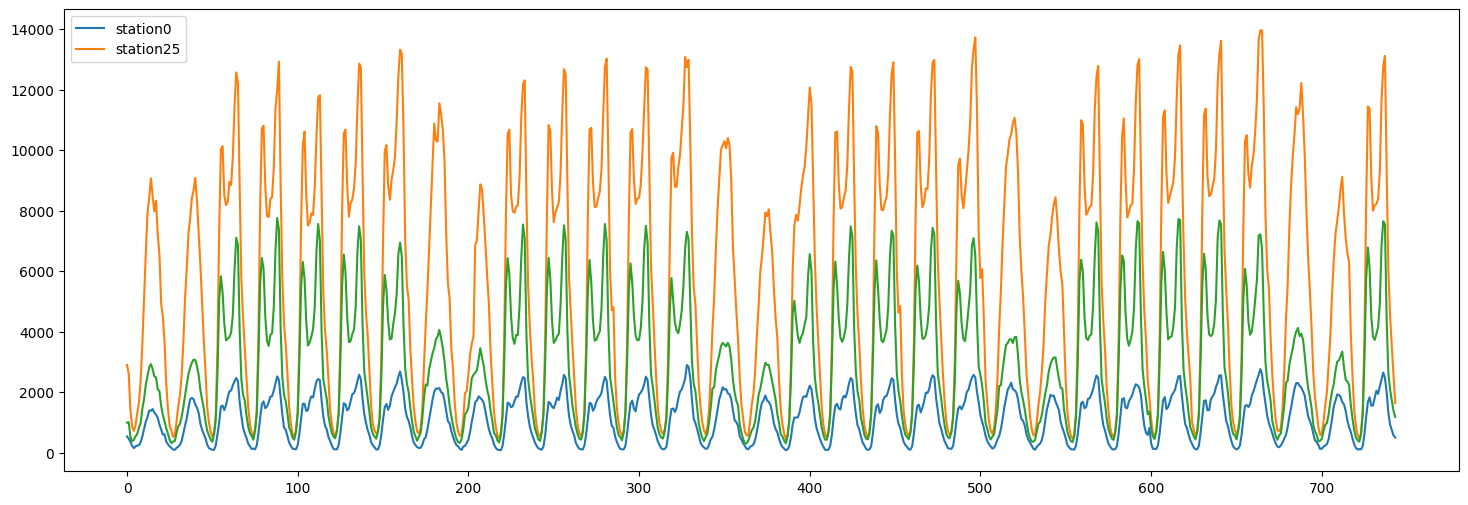

In [9]:
plt.figure(figsize=(18, 6))
plt.plot(stations[:, [0, 1, 8]])
plt.legend(["station0", "station25"])

Visualize the correlation between the timeseries in different routes.

Text(0, 0.5, 'station no.')

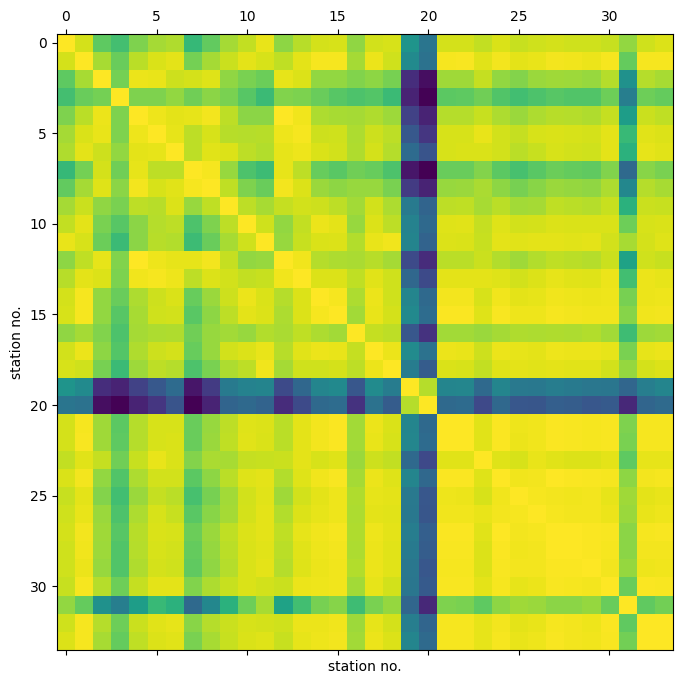

In [10]:
plt.figure(figsize=(8, 8))
plt.matshow(np.corrcoef(stations.T), 0)
plt.xlabel("station no.")
plt.ylabel("station no.")

## **3.Train-validation-test splitting** 

In [11]:
train_size, val_size = 0.5, 0.2

def preprocess(data_array: np.ndarray, train_size: float, val_size: float):
    """Splits data into train/val/test sets and normalizes the data.

    Args:
        data_array: ndarray of shape `(num_time_steps, num_routes)`
        train_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the train split.
        val_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the validation split.

    Returns:
        `train_array`, `val_array`, `test_array`
    """

    num_time_steps = data_array.shape[0]
    num_train, num_val = (
        int(num_time_steps * train_size),
        int(num_time_steps * val_size),
    )
    train_array = data_array[:num_train]
    mean, std = train_array.mean(axis=0), train_array.std(axis=0)

    train_array = (train_array - mean) / std
    val_array = (data_array[num_train : (num_train + num_val)] - mean) / std
    test_array = (data_array[(num_train + num_val) :] - mean) / std

    return train_array, val_array, test_array


train_array, val_array, test_array = preprocess(stations, train_size, val_size)

print(f"train set size: {train_array.shape}")
print(f"validation set size: {val_array.shape}")
print(f"test set size: {test_array.shape}")

train set size: (372, 34)
validation set size: (148, 34)
test set size: (224, 34)


## **4.Creating Tensorflow Datasets (Data Loaders)**

In [12]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

batch_size = 16
input_sequence_length = 24
forecast_horizon = 1
multi_horizon = False


def create_tf_dataset(
    data_array: np.ndarray,
    input_sequence_length: int,
    forecast_horizon: int,
    batch_size: int = 128,
    shuffle=True,
    multi_horizon=True,
):
    """Creates tensorflow dataset from numpy array.

    This function creates a dataset where each element is a tuple `(inputs, targets)`.
    `inputs` is a Tensor
    of shape `(batch_size, input_sequence_length, num_routes, 1)` containing
    the `input_sequence_length` past values of the timeseries for each node.
    `targets` is a Tensor of shape `(batch_size, forecast_horizon, num_routes)`
    containing the `forecast_horizon`
    future values of the timeseries for each node.

    Args:
        data_array: np.ndarray with shape `(num_time_steps, num_routes)`
        input_sequence_length: Length of the input sequence (in number of timesteps).
        forecast_horizon: If `multi_horizon=True`, the target will be the values of the timeseries for 1 to
            `forecast_horizon` timesteps ahead. If `multi_horizon=False`, the target will be the value of the
            timeseries `forecast_horizon` steps ahead (only one value).
        batch_size: Number of timeseries samples in each batch.
        shuffle: Whether to shuffle output samples, or instead draw them in chronological order.
        multi_horizon: See `forecast_horizon`.

    Returns:
        A tf.data.Dataset instance.
    """

    inputs = timeseries_dataset_from_array(
        np.expand_dims(data_array[:-forecast_horizon], axis=-1),
        None,
        sequence_length=input_sequence_length,
        shuffle=False,
        batch_size=batch_size,
    )

    target_offset = (
        input_sequence_length
        if multi_horizon
        else input_sequence_length + forecast_horizon - 1
    )
    target_seq_length = forecast_horizon if multi_horizon else 1
    targets = timeseries_dataset_from_array(
        data_array[target_offset:],
        None,
        sequence_length=target_seq_length,
        shuffle=False,
        batch_size=batch_size,
    )

    dataset = tf.data.Dataset.zip((inputs, targets))
    if shuffle:
        dataset = dataset.shuffle(100)

    return dataset.prefetch(16).cache()


train_dataset, val_dataset = (
    create_tf_dataset(data_array, input_sequence_length, forecast_horizon, batch_size)
    for data_array in [train_array, val_array]
)

test_dataset = create_tf_dataset(
    test_array,
    input_sequence_length,
    forecast_horizon,
    batch_size=test_array.shape[0],
    shuffle=False,
    multi_horizon=multi_horizon,
)


## **5.Create Graph for roads (DO NOT NEED TO RUN THESE 2 BLOCKS)**

In [13]:

def compute_adjacency_matrix(
    station_distances: np.ndarray, sigma2: float, epsilon: float
):
    """Computes the adjacency matrix from distances matrix.

    It uses the formula in https://github.com/VeritasYin/STGCN_IJCAI-18#data-preprocessing to
    compute an adjacency matrix from the distance matrix.
    The implementation follows that paper.

    Args:
        route_distances: np.ndarray of shape `(num_routes, num_routes)`. Entry `i,j` of this array is the
            distance between roads `i,j`.
        sigma2: Determines the width of the Gaussian kernel applied to the square distances matrix.
        epsilon: A threshold specifying if there is an edge between two nodes. Specifically, `A[i,j]=1`
            if `np.exp(-w2[i,j] / sigma2) >= epsilon` and `A[i,j]=0` otherwise, where `A` is the adjacency
            matrix and `w2=route_distances * route_distances`

    Returns:
        A boolean graph adjacency matrix.
    """
    num_stations = station_distances.shape[0]
    station_distances = station_distances / 10000.0
    w2, w_mask = (
        station_distances * station_distances,
        np.ones([num_stations, num_stations]) - np.identity(num_stations),
    )
    return (np.exp(-w2 / sigma2) >= epsilon) * w_mask


In [14]:
class GraphInfo:
    def __init__(self, edges: typing.Tuple[list, list], num_nodes: int):
        self.edges = edges
        self.num_nodes = num_nodes


sigma2 = 0.1
epsilon = 0.5

adjacency_matrix = compute_adjacency_matrix(station_distances, sigma2, epsilon)
node_indices, neighbor_indices = np.where(adjacency_matrix == 1)
graph = GraphInfo(
    edges=(node_indices.tolist(), neighbor_indices.tolist()),
    num_nodes=adjacency_matrix.shape[0],
)
print(f"number of nodes: {graph.num_nodes}, number of edges: {len(graph.edges[0])}")

number of nodes: 34, number of edges: 1122


## **5.Create graph based on Distance Band & KNN (RUN THIS INSTEAD)**

In [16]:
class GraphInfo:
    def __init__(self, edges: typing.Tuple[list, list], num_nodes: int):
        self.edges = edges
        self.num_nodes = num_nodes


adjacency_matrix = station_distances
node_indices, neighbor_indices = np.where(adjacency_matrix == 1)
graph = GraphInfo(
    edges=(node_indices.tolist(), neighbor_indices.tolist()),
    num_nodes=adjacency_matrix.shape[0],
)
print(f"number of nodes: {graph.num_nodes}, number of edges: {len(graph.edges[0])}")

number of nodes: 34, number of edges: 2


# **6.Building Network Structure**

## **6.1.GCN Layer**

In [17]:

class GraphConv(layers.Layer):
    def __init__(
        self,
        in_feat,
        out_feat,
        graph_info: GraphInfo,
        aggregation_type="mean",
        combination_type="concat",
        activation: typing.Optional[str] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.graph_info = graph_info
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.weight = tf.Variable(
            initial_value=keras.initializers.glorot_uniform()(
                shape=(in_feat, out_feat), dtype="float32"
            ),
            trainable=True,
        )
        self.activation = layers.Activation(activation)

    def aggregate(self, neighbour_representations: tf.Tensor):
        aggregation_func = {
            "sum": tf.math.unsorted_segment_sum,
            "mean": tf.math.unsorted_segment_mean,
            "max": tf.math.unsorted_segment_max,
        }.get(self.aggregation_type)

        if aggregation_func:
            return aggregation_func(
                neighbour_representations,
                self.graph_info.edges[0],
                num_segments=self.graph_info.num_nodes,
            )

        raise ValueError(f"Invalid aggregation type: {self.aggregation_type}")

    def compute_nodes_representation(self, features: tf.Tensor):
        """Computes each node's representation.

        The nodes' representations are obtained by multiplying the features tensor with
        `self.weight`. Note that
        `self.weight` has shape `(in_feat, out_feat)`.

        Args:
            features: Tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        return tf.matmul(features, self.weight)

    def compute_aggregated_messages(self, features: tf.Tensor):
        neighbour_representations = tf.gather(features, self.graph_info.edges[1])
        aggregated_messages = self.aggregate(neighbour_representations)
        return tf.matmul(aggregated_messages, self.weight)

    def update(self, nodes_representation: tf.Tensor, aggregated_messages: tf.Tensor):
        if self.combination_type == "concat":
            h = tf.concat([nodes_representation, aggregated_messages], axis=-1)
        elif self.combination_type == "add":
            h = nodes_representation + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        return self.activation(h)

    def call(self, features: tf.Tensor):
        """Forward pass.

        Args:
            features: tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        nodes_representation = self.compute_nodes_representation(features)
        aggregated_messages = self.compute_aggregated_messages(features)
        return self.update(nodes_representation, aggregated_messages)


## **6.2.LSTM Embedding**

In [18]:

class LSTMGC(layers.Layer):
    """Layer comprising a convolution layer followed by LSTM and dense layers."""

    def __init__(
        self,
        in_feat,
        out_feat,
        lstm_units: int,
        input_seq_len: int,
        output_seq_len: int,
        graph_info: GraphInfo,
        graph_conv_params: typing.Optional[dict] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # graph conv layer
        if graph_conv_params is None:
            graph_conv_params = {
                "aggregation_type": "mean",
                "combination_type": "concat",
                "activation": None,
            }
        self.graph_conv = GraphConv(in_feat, out_feat, graph_info, **graph_conv_params)

        self.lstm = layers.LSTM(lstm_units, activation="relu")
        self.dense = layers.Dense(output_seq_len)

        self.input_seq_len, self.output_seq_len = input_seq_len, output_seq_len

    def call(self, inputs):
        """Forward pass.

        Args:
            inputs: tf.Tensor of shape `(batch_size, input_seq_len, num_nodes, in_feat)`

        Returns:
            A tensor of shape `(batch_size, output_seq_len, num_nodes)`.
        """

        # convert shape to  (num_nodes, batch_size, input_seq_len, in_feat)
        inputs = tf.transpose(inputs, [2, 0, 1, 3])

        gcn_out = self.graph_conv(
            inputs
        )  # gcn_out has shape: (num_nodes, batch_size, input_seq_len, out_feat)
        shape = tf.shape(gcn_out)
        num_nodes, batch_size, input_seq_len, out_feat = (
            shape[0],
            shape[1],
            shape[2],
            shape[3],
        )

        # LSTM takes only 3D tensors as input
        gcn_out = tf.reshape(gcn_out, (batch_size * num_nodes, input_seq_len, out_feat))
        lstm_out = self.lstm(
            gcn_out
        )  # lstm_out has shape: (batch_size * num_nodes, lstm_units)

        dense_output = self.dense(
            lstm_out
        )  # dense_output has shape: (batch_size * num_nodes, output_seq_len)
        output = tf.reshape(dense_output, (num_nodes, batch_size, self.output_seq_len))
        return tf.transpose(
            output, [1, 2, 0]
        )  # returns Tensor of shape (batch_size, output_seq_len, num_nodes)


# **7.Model Training**

In [1]:
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Epoch 1/20
22/22 [==============================] - 6s 153ms/step - loss: 0.9152 - val_loss: 0.9401
Epoch 2/20
22/22 [==============================] - 4s 197ms/step - loss: 0.8063 - val_loss: 0.8264
Epoch 3/20
22/22 [==============================] - 2s 114ms/step - loss: 0.6944 - val_loss: 0.6859
Epoch 4/20
22/22 [==============================] - 2s 110ms/step - loss: 0.5475 - val_loss: 0.4794
Epoch 5/20
22/22 [==============================] - 3s 128ms/step - loss: 0.3698 - val_loss: 0.2944
Epoch 6/20
22/22 [==============================] - 2s 108ms/step - loss: 0.2618 - val_loss: 0.2338
Epoch 7/20
22/22 [==============================] - 2s 110ms/step - loss: 0.2225 - val_loss: 0.2127
Epoch 8/20
22/22 [==============================] - 2s 109ms/step - loss: 0.2030 - val_loss: 0.1984
Epoch 9/20
22/22 [==============================] - 3s 127ms/step - loss: 0.1880 - val_loss: 0.1860
Epoch 10/20
22/22 [==============================] - 2s 114ms/step - loss: 0.1754 - val_loss: 0.1739

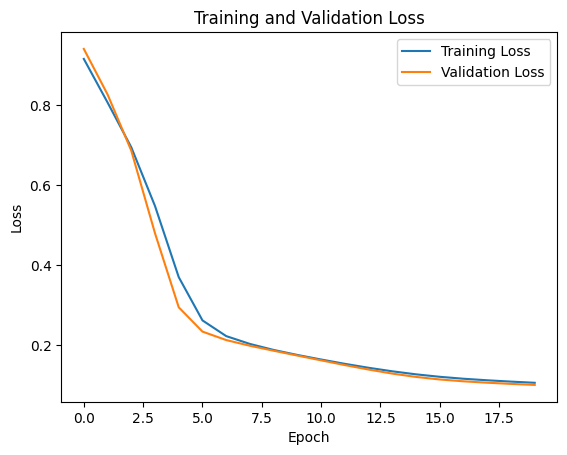

In [19]:
in_feat = 1
batch_size = 16
epochs = 20
input_sequence_length = 24
forecast_horizon = 1
multi_horizon = False
out_feat = 10
lstm_units = 64
graph_conv_params = {
    "aggregation_type": "mean",
    "combination_type": "concat",
    "activation": None,
}

st_gcn = LSTMGC(
    in_feat,
    out_feat,
    lstm_units,
    input_sequence_length,
    forecast_horizon,
    graph,
    graph_conv_params,
)
inputs = layers.Input((input_sequence_length, graph.num_nodes, in_feat))
outputs = st_gcn(inputs)

model = keras.models.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0002),
    loss=keras.losses.MeanSquaredError(),
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
)


plot_loss(history)


# **8. Model Evaluation**

7/7 [==============================] - 1s 68ms/step
naive MAE: 0.19642073063602225, model MAE: 0.12161177708046722


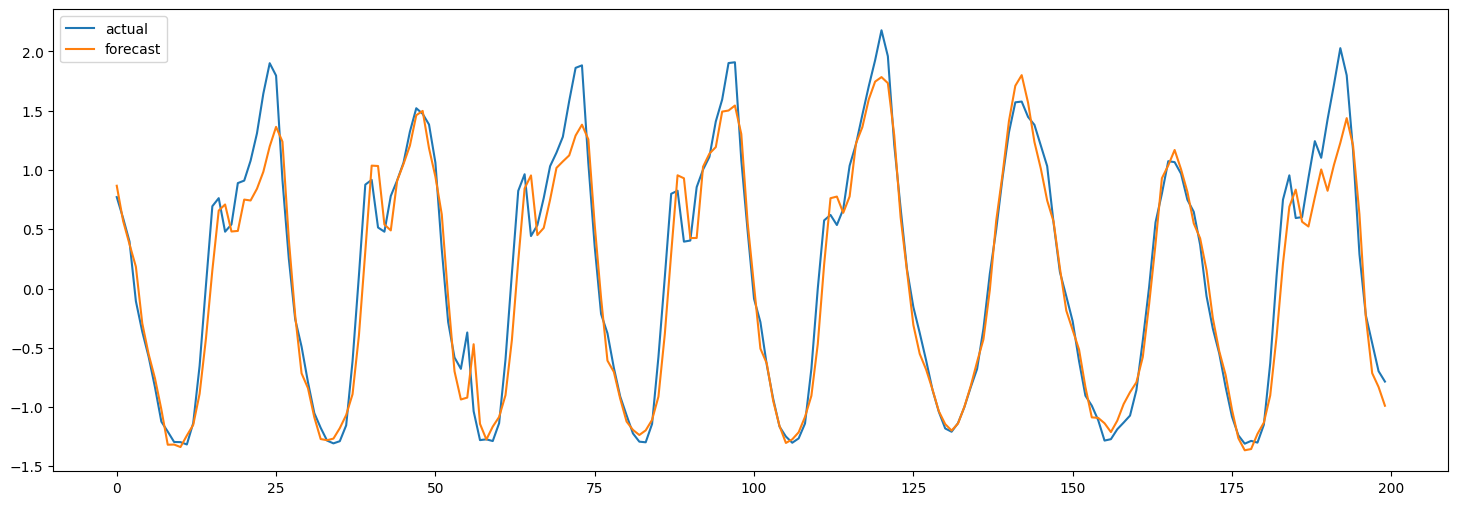

In [20]:
x_test, y = next(test_dataset.as_numpy_iterator())
y_pred = model.predict(x_test)
plt.figure(figsize=(18, 6))
plt.plot(y[:, 0, 0])
plt.plot(y_pred[:, 0, 0])
plt.legend(["actual", "forecast"])

naive_mse, model_mse = (
    np.square(x_test[:, -1, :, 0] - y[:, 0, :]).mean(),
    np.square(y_pred[:, 0, :] - y[:, 0, :]).mean(),
)
print(f"naive MAE: {naive_mse}, model MAE: {model_mse}")

In [21]:
y_pred.shape

(200, 1, 34)

In [22]:
# calculate model NMSE
model_mse = np.square(y_pred[:, 0, :] - y[:, 0, :]).mean()
y_var = np.var(y)
# calculate the NMSE
model_nmse = model_mse / y_var
model_nmse

0.1117265404238907

In [24]:
# calcualte model NRMSE on all stations averaged
model_RMSE = np.sqrt(np.square(y_pred[:, 0, :] - y[:, 0, :]).mean())
model_NRMSE = model_RMSE / (np.max(y_pred[:, 0, :]) - np.min(y[:, 0, :]))
model_NRMSE

0.07014083753862356